<header><font size="+2"> <center> <b> Solving the Ising model with the Metropolis Algorithm </b></center></font></header>

In [22]:
import numpy as np
import multiprocessing as mp
import itertools as it

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

(I know these could be expressed as matrix ops, so far they're fast enough, though)

In [14]:
def simulate(N, T, J = 1, niter = 5000):
    s = 2 * (np.random.uniform(size=(N, N)) > 0.5) - 1
    
    def p(ind, N):
        return ind % N
    
    def energy(s, J):
        E = 0
        N = s.shape[0]
        
        for i in range(N):
            for j in range(N):
                dE = s[i, j] * (
                    s[p(i+1, N), j] + s[p(i-1, N), j] 
                    + s[i, p(j+1, N)] + s[i, p(j-1,N)]
                )
                E -= 0.5 * J * dE
                
        return E

    
    E = energy(s, J)
    
    for itr in range(niter):
        indx = np.random.randint(0, N)
        indy = np.random.randint(0, N)
        
        dE = 2 * J * s[indy, indx] *  (  s[p(indy+1, N), indx]\
                                       + s[p(indy-1, N), indx]\
                                       + s[indy, p(indx-1, N)]
                                       + s[indy, p(indx+1, N)])
        
        # accept
        # don't need exp!
#         if np.exp(-1 * ((E + dE) / T)) > np.exp(-1 * (E / T)):
        if (E + dE) < E:
            s[indy, indx] = s[indy, indx] * -1
            E = E + dE
        # accept even if not an improvement
        elif np.random.rand() <= np.exp(-1 * (dE / T)):
            s[indy, indx] = s[indy,indx] *-1
            E = E + dE  
    
    return s

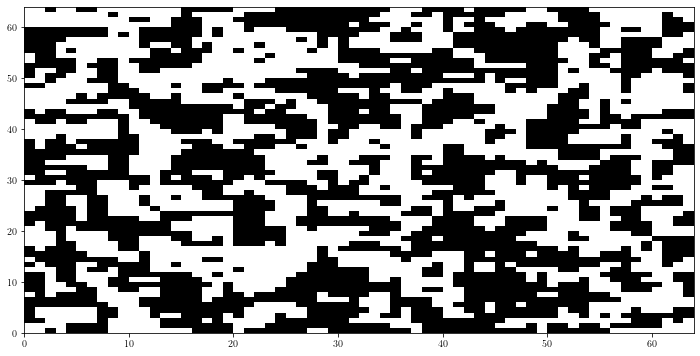

In [23]:
s = simulate(64, 2.26, niter=10000)
plt.pcolormesh(s, cmap="binary");

## Sanity check - magnetization

In [24]:
m = []
for T in np.linspace(0.1, 10, 20):
    s = simulate(32, T, niter=20000)
    m.append(s.mean())    

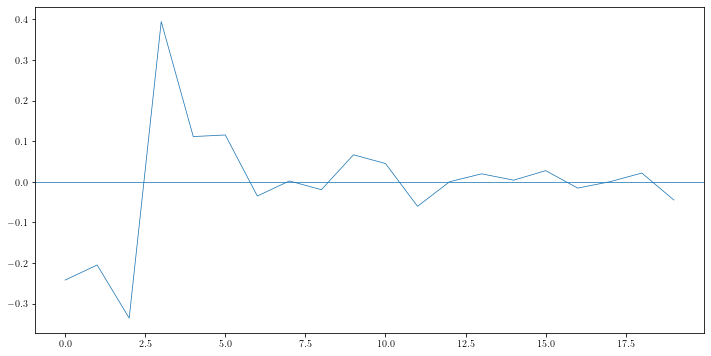

In [25]:
plt.plot(m);
plt.axhline(0);

# Generate data for the GAN

In [37]:
pool = mp.Pool(mp.cpu_count() // 2)

In [47]:
Ndata = 10000

In [39]:
Tc = 2.269185

In [48]:
N = 64
T = 1
J = 1

  Generate Ndata **equilibrium** states at T

In [ ]:
res = pool.starmap(simulate, it.repeat((64, T, J, 10000), Ndata))

Dump them concatenated  

In [ ]:
np.array(res).tofile("mcdata/" + str(T) + ".dat")

In [33]:
pool.close()